In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F
from collections import defaultdict
import numpy as np
# use_cuda = torch.cuda.is_available()
use_cuda = False

In [2]:
from torch_utils import pad_sequence
import os

In [3]:
PAD_TOKEN = 0
BOS_TOKEN = 1
NAN_TOKEN = 2
EOS_TOKEN = 3
SPECIAL_TOKENS = 4
OCCURING_SPECIAL_TOKENS = 1

In [4]:
# class DatasetFilesLocation:
#     def __init__(self, train, dev, test, tokens):
#         self.train = train
#         self.dev = dev
#         self.test = test
#         self.tokens = tokens

In [9]:
# src_files = DatasetFilesLocation(
#     train='../preprocessed/he-en/src.train.txt',
#     dev='../preprocessed/he-en/src.dev.txt',
#     test='../preprocessed/he-en/src.test.txt',
#     tokens='../preprocessed/he-en/src.tokens.txt')

# trg_files = DatasetFilesLocation(
#     train='../preprocessed/he-en/tgt.train.txt',
#     dev='../preprocessed/he-en/tgt.dev.txt',
#     test='../preprocessed/he-en/tgt.test.txt',
#     tokens='../preprocessed/he-en/tgt.tokens.txt')

In [10]:
class Lang:
    def __init__(self, tokens_file_path):
        self.idx2word = defaultdict(lambda: "<NAN/>")
        self.word2idx = defaultdict(lambda: NAN_TOKEN)
        with open(tokens_file_path) as tokens_file:
            tokens = tokens_file.readlines()
            for word, idx in map(lambda x: x.strip().split(), tokens):
                idx = int(idx) + SPECIAL_TOKENS
                self.idx2word[idx] = word
                self.word2idx[word] = idx
            assert PAD_TOKEN not in self.idx2word
            assert BOS_TOKEN not in self.idx2word
            assert EOS_TOKEN not in self.idx2word
            for word, idx in [('<PAD/>', PAD_TOKEN), ('<S>', BOS_TOKEN),
                              ('</S>', EOS_TOKEN), ('<NAN/>', NAN_TOKEN)]:
                self.idx2word[idx] = word
                self.word2idx[word] = idx
    
    def convert(self, sentence):
        if isinstance(sentence, str):
            sentence = sentence.strip().split()
        return [BOS_TOKEN] + list(map(lambda word: self.word2idx[word], sentence)) + [EOS_TOKEN]
    
    def convert_batch(self, sents):
        
        batch_max_length = 0
        for sent in sents:
            batch_max_length = max(batch_max_length, len(sent))
            
#         print(batch_max_length)
        
        result = np.zeros(shape=(len(sents), batch_max_length + 1 + 1))
        mask = np.zeros(shape=(len(sents), batch_max_length + 1 + 1))
        
        for sent_id, sent in enumerate(sents):
            sent = sent[:batch_max_length]
            current = self.convert(sent)
            result[sent_id, :len(current)] = current
            mask[sent_id, :len(current)] = 1.0
            
        return result, mask
    
    def input_size(self):
        return len(self.idx2word.keys())
    
    def output_size(self):
        return len(self.idx2word.keys())# - SPECIAL_TOKENS + OCCURING_SPECIAL_TOKENS
    
    def get_word(self, idx):
        return self.idx2word[idx]# + SPECIAL_TOKENS - OCCURING_SPECIAL_TOKENS]
    
    def get_eos(self):
        return EOS_TOKEN #OCCURING_SPECIAL_TOKENS - 1

In [11]:
def read_file(filename):
    with open(filename) as file:
        return list(map(lambda s: s.strip().split(" "), file.readlines()))

In [46]:
def read_problem(path, n_sents=None):
    modes = ["train",  "dev", "test"]
    datasets = ["src", "tgt"]
    file_template = "{}.{}.txt"
    
    result = {}
    for mode in modes:
        src = read_file(os.path.join(path, file_template.format("src", mode)))
        tgt = read_file(os.path.join(path, file_template.format("tgt", mode)))
        
        assert len(src) == len(tgt)
        
#         result[mode] = list(zip(src, tgt))
        if n_sents is not None:
            result[mode] = (src[:n_sents], tgt[:n_sents])
        else:
            result[mode] = (src, tgt)
        
    src_lang = Lang(os.path.join(path, file_template.format("src", "tokens")))
    tgt_lang = Lang(os.path.join(path, file_template.format("tgt", "tokens")))
    return result, src_lang, tgt_lang
        
        

In [47]:
d, src, tgt = read_problem("../preprocessed/he-en/", n_sents=1000)

In [50]:
# len(d["train"][0])

In [14]:
src.convert_batch(d["test"][0][:3])

(array([[ 1.,  6.,  4., 24., 88., 39.,  3.,  0.],
        [ 1.,  6.,  6.,  6., 48., 80., 28.,  3.],
        [ 1.,  6.,  6., 14., 17.,  3.,  0.,  0.]]),
 array([[1., 1., 1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 0., 0.]]))

In [15]:

class BatchSampler:
    def __init__(self, dataset, src_lang, tgt_lang, batch_size):
        self.train = dataset["train"]
        self.dev = dataset["dev"]
        self.test = dataset["test"]
        
        self.src_lang = src_lang
        self.tgt_lang = tgt_lang
        
        self.batch_size = batch_size
    
    def __len__(self):
        return len(self.train)//self.batch_size + 1
        
    def __iter__(self):
        self.position = 0
        return self
    
    def reset(self):
        self.position = 0
        
    
    def get_batch(self, x, y):
        x, x_mask = self.src_lang.convert_batch(x)
        y, y_mask = self.tgt_lang.convert_batch(y)
        
        x = Variable(torch.from_numpy(x.astype(np.int64))).contiguous()
        x_mask = Variable(torch.from_numpy(x_mask.astype(np.float32))).contiguous()
        
        y = Variable(torch.from_numpy(y.astype(np.int64))).contiguous()
        y_mask = Variable(torch.from_numpy(y_mask.astype(np.float32))).contiguous()
        
        return (x, x_mask), (y, y_mask)
    
        
    def __next__(self):
            if self.position >= len(self.train[0]):
                raise StopIteration()
                
            x = self.train[0][self.position:self.position + self.batch_size]
            y = self.train[1][self.position:self.position + self.batch_size]
            
            self.position += self.batch_size
            return self.get_batch(x, y)

        

In [16]:
# def form_batch_variable(lang, sentences):
#     sentences = list(map(lang.convert, sentences))
#     sentences = sorted(sentences, key=len, reverse=True)
#     lengths = list(map(len, sentences))
#     sentences = list(map(lambda sentence: Variable(torch.LongTensor(sentence)), sentences))
#     batch = pad_sequence(sentences, batch_first=True, padding_value=PAD_TOKEN)
#     if use_cuda:
#         batch = batch.cuda()
#     return torch.nn.utils.rnn.pack_padded_sequence(batch, lengths, batch_first=True)

In [17]:
class HyperParameters:
    def __init__(self):
        self.max_length = 100
        self.enc_hidden_size = 128
        self.enc_emb_size = 128
        self.enc_layers = 1
        self.enc_dropout = 0.1
        self.enc_bidirectional = True
        
        self.dec_hidden_size = 128
        self.dec_emb_size = self.enc_emb_size
        self.dec_layers = 1
        self.dec_dropout = 0.1
        self.dec_bidirectional = True
        
        self.batch_size = 100
        self.learning_rate = 0.001
        self.clip = 0.25
     
    def get_enc_output_size(self):
        return self.enc_hidden_size * (int(self.enc_bidirectional) + 1)
    
    def get_dec_output_size(self):
        return self.dec_hidden_size * (int(self.dec_bidirectional) + 1)
    
    def get_dec_state_size(self):
        return self.dec_hidden_size * (int(self.dec_bidirectional) + 1) * self.dec_layers

In [18]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hp):
        super(EncoderRNN, self).__init__()

        self.embedding = nn.Embedding(num_embeddings=input_size,
                                      embedding_dim=hp.enc_emb_size,
                                      padding_idx=PAD_TOKEN)
        
        self.gru = nn.GRU(input_size=hp.enc_emb_size,
                          hidden_size=hp.enc_hidden_size,
                          batch_first=True,
                          dropout=hp.enc_dropout,
                          num_layers=hp.enc_layers,
                          bidirectional=hp.enc_bidirectional)
        self.num_directions = (int(hp.enc_bidirectional) + 1)
        self.num_layers = hp.enc_layers
        self.hidden_size = hp.enc_hidden_size

    def forward(self, input_batch, hidden=None):
        """
        """

        if (hidden is None):
            hidden = self.init_hidden(input_batch.size(0))
        embedded = self.embedding(input_batch).contiguous()
#         packed = torch.nn.utils.rnn.pack_padded_sequence(embedded, input_lengths, batch_first=True)
        outputs, _ = self.gru(embedded, hidden)
#         outputs, output_lengths = torch.nn.utils.rnn.pad_packed_sequence(
#             outputs, padding_value=PAD_TOKEN, batch_first=True)
#         print(outputs.size())
        return outputs

    def init_hidden(self, batch_size):
        result = Variable(torch.zeros(
            self.num_layers * self.num_directions, batch_size, self.hidden_size))
        if use_cuda:
            return result.cuda()
        else:
            return result

In [19]:
# def get_mask(lengths):
#     batch_size = lengths.size(0)
#     max_len = lengths[0]
#     time = torch.arange(max_len).repeat(batch_size, 1)
#     lengths = lengths.view(-1, 1).type(torch.FloatTensor)
#     if (use_cuda):
#         time = time.cuda()
#         lengths = lengths.cuda()

#     mask = Variable((time < lengths).type(torch.FloatTensor))
#     if (use_cuda):
#         return mask.cuda()
#     return mask

In [20]:
class Attn(nn.Module):
    def __init__(self, hp):
        super(Attn, self).__init__()
        self.attn = nn.Linear(hp.get_enc_output_size() + hp.get_dec_state_size(), 1)

    def forward(self, hidden, encoder_outputs, mask):
        '''
        :param hidden: 
            previous hidden state of the decoder, in shape (layers * directions, B, HD)
        :param encoder_outputs:
            encoder outputs from Encoder, in shape (B, T, HE)
        :param encoder_output_lengths:
            lengths of encoded sentences, in shape (B,)
        :return
            attention energies in shape (B,T)
        '''
        batch_size = encoder_outputs.size(0)
        max_len = encoder_outputs.size(1)

        hidden = hidden.transpose(0, 1).contiguous() # [B, l * d, HD]
        hidden = hidden.view(batch_size, -1) # [B, HD * layers * directions]
        hidden = hidden.repeat(max_len, 1, 1).transpose(0, 1) # [B, T, HD * layers * directions]
        
        energies = self.attn(torch.cat((hidden, encoder_outputs), -1)).view(batch_size, max_len) # [B, T, 1]

        
        energies = energies * mask
        energies = F.softmax(energies)
        energies = energies * mask
        energies = energies / energies.sum(1).view(-1, 1) # [B, T]
        
        return (energies.view(batch_size, max_len, 1) * encoder_outputs).sum(1) #[B, HE]

In [21]:
class DecoderRNN(nn.Module):
    def __init__(self, input_size, output_size, hp):
        super(DecoderRNN, self).__init__()

        self.embedding = nn.Embedding(input_size, hp.dec_emb_size, padding_idx=PAD_TOKEN)
        self.attn = Attn(hp)
        self.gru = nn.GRU(input_size=hp.dec_emb_size + hp.get_enc_output_size(),
                          hidden_size=hp.dec_hidden_size,
                          num_layers=hp.dec_layers,
                          batch_first=True,
                          dropout=hp.dec_dropout,
                          bidirectional=hp.dec_bidirectional)
        self.out = nn.Linear(hp.get_dec_output_size(), output_size)

        self.num_layers = hp.dec_layers
        self.num_directions = int(hp.dec_bidirectional) + 1
        self.output_size = output_size
        self.hidden_size = hp.dec_hidden_size


    def forward(self, input, encoder_outputs, mask, hidden=None):
        """
            input: [B,]
            encoder_outputs: [B, T, HE]
            hidden: [B, layers * directions, HD]
        """
        batch_size = input.size(0)
        if hidden is None:
            hidden = self.init_hidden(batch_size)
#         embedded = self.embedding(input.view(-1, 1))
        embedded = self.embedding(input)
#         print(embedded.size())
        context = self.attn(hidden, encoder_outputs, mask).view(batch_size, -1)
#         print(context.size())
        rnn_input = torch.cat((embedded, context), -1).view(batch_size, 1, -1)
        
#         print("RNN input", rnn_input.size())
        output, next_hidden = self.gru(rnn_input, hidden)
        output = self.out(output).view(batch_size, self.output_size)
        output = F.log_softmax(output, -1)
        
        return output, next_hidden

    def init_hidden(self, batch_size):
        result = Variable(torch.zeros(
            self.num_layers * self.num_directions, batch_size, self.hidden_size))
        if use_cuda:
            return result.cuda()
        else:
            return result

In [35]:
class Seq2Seq(nn.Module):
    def __init__(self, source_lang, target_lang, hp):
        super(Seq2Seq, self).__init__()
        self.source_lang = source_lang
        self.target_lang = target_lang
        self.encoder = EncoderRNN(source_lang.input_size(), hp)
        self.decoder = DecoderRNN(target_lang.input_size(), target_lang.input_size(), hp)
        self.max_length = hp.max_length
        self.criterion = nn.NLLLoss(reduce=False, size_average=False)
        
#     def translate(self, input_seq):

# #         input_batch, input_lengths = torch.nn.utils.rnn.pad_packed_sequence(
# #             input_seq, batch_first=True, padding_value=PAD_TOKEN)
# #         encoder_outputs, encoder_output_lengths = self.encoder(input_batch, input_lengths)
# #         encoder_output_lengths = torch.LongTensor(encoder_output_lengths)
# #         mask = get_mask(encoder_output_lengths)
        
# #         batch_size = input_batch.size(0)
        
#         dec_input = Variable(torch.LongTensor([BOS_TOKEN] * batch_size))
#         if use_cuda:
#             dec_input = dec_input.cuda()
# #         max_length = min(self.max_length, 2 * encoder_output_lengths[0])
#         hidden = None
#         translations = [[BOS_TOKEN] for _ in range(batch_size)]
#         for i in range(max_length):
#             output, hidden = self.decoder(dec_input, encoder_outputs, mask=mask, hidden=hidden)
#             _, output_idx = torch.max(output, -1)
#             for j in range(batch_size):
#                 if translations[j][-1] != target_lang.get_eos():
#                     translations[j].append(output_idx[j].data[0])
#             dec_input = Variable(torch.LongTensor([tr[-1] for tr in translations]))
#             if use_cuda:
#                 dec_input = dec_input.cuda()
#         return [' '.join(map(target_lang.get_word, elem)) for elem in translations]

    def translate(self, input_batch, mask):
        batch_size = input_batch.size()[0]
        encoder_outputs = self.encoder(input_batch)
        if use_cuda:
            dec_input = dec_input.cuda()
        
        hidden = None
        
        logits = []
        word_indices = []
#         outputs = []
        
        dec_input = Variable(torch.LongTensor([BOS_TOKEN] * batch_size))
        
        MAX_LENGTH = 100
        translations = [[BOS_TOKEN] for _ in range(batch_size)]
        converged = np.zeros(shape=(batch_size, ))
        for i in range(MAX_LENGTH):     
            output, hidden = self.decoder(dec_input, encoder_outputs, mask=mask, hidden=hidden)
            _, output_idx = torch.max(output, -1)
                
            for j in range(batch_size):
                if translations[j][-1] != self.target_lang.get_eos():
                    translations[j].append(output_idx[j].data[0])
                else:
                    converged[j] = True
            dec_input = Variable(torch.LongTensor([tr[-1] for tr in translations]))
            
            
            if np.all(converged):
                break
            
         
            
#         return translations
        return [' '.join(map(self.target_lang.get_word, elem)) for elem in translations]
    
    def forward(self, input_batch, mask, output_batch, out_mask):
#         input_batch, input_lengths = torch.nn.utils.rnn.pad_packed_sequence(
#             input_seq, batch_first=True, padding_value=PAD_TOKEN)
#         encoder_outputs, encoder_output_lengths = self.encoder(input_batch, input_lengths)
        encoder_outputs = self.encoder(input_batch)
#         encoder_output_lengths = torch.LongTensor(encoder_output_lengths)
#         mask = get_mask(encoder_output_lengths)
#         batch_size = input_batch.size(0)
        
        if use_cuda:
            dec_input = dec_input.cuda()
        
        hidden = None
        
        logits = []
#         output_batch, output_lengths = torch.nn.utils.rnn.pad_packed_sequence(output_seq,
#                                                                               batch_first=True,
#                                                                               padding_value=PAD_TOKEN)
#         output_lengths = torch.LongTensor(output_lengths)
#         out_mask = get_mask(output_lengths)
        loss = 0
        outputs = []
        for i in range(out_mask.size()[1] - 1):
           
            output, hidden = self.decoder(output_batch[:, i], encoder_outputs, mask=mask, hidden=hidden)
            loss += (self.criterion(output, output_batch[:, i + 1]) * out_mask[:, i + 1]).sum()
        
        loss /= out_mask.sum()
        return loss
        

In [36]:
import tqdm
def trainS2S(s2s, batch_sampler, hp):
    s2s.train()
    losses = []
#     hp.batch_size = 100
#     assert(len(src) == len(trg))
    
    optimizer = torch.optim.Adam(s2s.parameters(), lr=hp.learning_rate)
    
    for epoch_id in range(hp.n_epochs):
#         batch_sampler.reset()
        for batch_id, ((input, input_mask), (output, output_mask)) in tqdm.tqdm(enumerate(batch_sampler)):
#         for i in tqdm.tqdm(range(0, len(src), hp.batch_size)):
#             src_batch = form_batch_variable(source_lang, src[i : i + hp.batch_size])
#             trg_batch = form_batch_variable(target_lang, trg[i : i + hp.batch_size])


            loss = s2s(input, input_mask, output, output_mask)
#             if (batch_id // hp.batch_size) % 100 == 0:
#                 print(loss.data[0])
            losses.append(loss.data[0])
            loss.backward()
            torch.nn.utils.clip_grad_norm(s2s.parameters(), hp.clip)
            optimizer.step()
    return losses
        

In [37]:
dummy_dataset = {
    "train": ( ["'a 'a d y r", "'a 'a h b ckh"], ["a a d i r", "e a h a v k h a"]),
    "test":None,
    "dev":None
    
}

In [38]:
batch_sampler = BatchSampler(dummy_dataset, src, tgt, 31)

In [39]:
hp = HyperParameters()
hp.batch_size = 100
hp.n_epochs = 20
s2s = Seq2Seq(src, tgt, hp)
trainS2S(s2s, batch_sampler, hp)

0it [00:00, ?it/s]/home/itasarom/.programs/anaconda2/envs/torch/lib/python3.5/site-packages/ipykernel/__main__.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
1it [00:00, 11.31it/s]
1it [00:00,  9.46it/s]
1it [00:00,  9.57it/s]
1it [00:00,  9.44it/s]
1it [00:00, 10.97it/s]
1it [00:00,  9.48it/s]
1it [00:00,  8.72it/s]
1it [00:00, 10.21it/s]
1it [00:00,  9.98it/s]
1it [00:00,  9.55it/s]
1it [00:00,  9.13it/s]
1it [00:00,  9.98it/s]
1it [00:00, 10.38it/s]
1it [00:00, 10.30it/s]
1it [00:00,  9.91it/s]
1it [00:00,  9.63it/s]
1it [00:00,  9.30it/s]
1it [00:00, 10.33it/s]
1it [00:00, 10.37it/s]
1it [00:00, 10.97it/s]


[3.002084732055664,
 2.6538538932800293,
 2.3275082111358643,
 2.0254383087158203,
 1.7580164670944214,
 1.5345267057418823,
 1.3483034372329712,
 1.1852436065673828,
 1.0418860912322998,
 0.919980525970459,
 0.8147149085998535,
 0.7196149826049805,
 0.632966160774231,
 0.5549482703208923,
 0.48462098836898804,
 0.42104572057724,
 0.3653680384159088,
 0.3198111057281494,
 0.2834157645702362,
 0.250639945268631]

In [269]:
s2s

Seq2Seq(
  (encoder): EncoderRNN(
    (embedding): Embedding(90, 128, padding_idx=0)
    (gru): GRU(128, 128, batch_first=True, dropout=0.1, bidirectional=True)
  )
  (decoder): DecoderRNN(
    (embedding): Embedding(32, 128, padding_idx=0)
    (attn): Attn(
      (attn): Linear(in_features=512, out_features=1)
    )
    (gru): GRU(384, 128, batch_first=True, dropout=0.1, bidirectional=True)
    (out): Linear(in_features=256, out_features=32)
  )
  (criterion): NLLLoss(
  )
)

In [51]:
batch_sampler = BatchSampler(d, src, tgt, 31)

In [57]:
hp = HyperParameters()
hp.n_epochs = 20
s2s = Seq2Seq(src, tgt, hp)
losses = trainS2S(s2s, batch_sampler, hp)

0it [00:00, ?it/s]/home/itasarom/.programs/anaconda2/envs/torch/lib/python3.5/site-packages/ipykernel/__main__.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
33it [00:05,  5.93it/s]
33it [00:04,  6.63it/s]
33it [00:05,  6.11it/s]
33it [00:05,  6.06it/s]
33it [00:05,  6.59it/s]
33it [00:05,  6.09it/s]
33it [00:05,  6.15it/s]
33it [00:05,  6.00it/s]
33it [00:05,  6.04it/s]
33it [00:05,  6.19it/s]
33it [00:05,  5.84it/s]
33it [00:07,  4.59it/s]
33it [00:05,  5.88it/s]
33it [00:05,  6.18it/s]
33it [00:05,  6.02it/s]
33it [00:05,  6.06it/s]
33it [00:05,  6.23it/s]
33it [00:05,  5.92it/s]
33it [00:05,  6.10it/s]
33it [00:05,  6.09it/s]


In [58]:
from matplotlib import pyplot as plt
%matplotlib inline

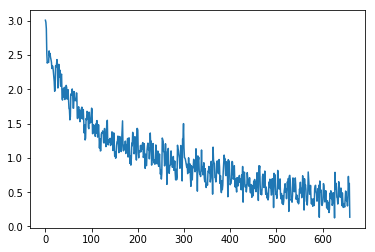

In [59]:
plt.plot(losses)

In [150]:
s2s.eval()

Seq2Seq(
  (encoder): EncoderRNN(
    (embedding): Embedding(90, 32, padding_idx=0)
    (gru): GRU(32, 128, batch_first=True, dropout=0.1, bidirectional=True)
  )
  (decoder): DecoderRNN(
    (embedding): Embedding(32, 32, padding_idx=0)
    (attn): Attn(
      (attn): Linear(in_features=512, out_features=1)
    )
    (gru): GRU(288, 128, batch_first=True, dropout=0.1, bidirectional=True)
    (out): Linear(in_features=256, out_features=32)
  )
  (criterion): NLLLoss(
  )
)

In [60]:
s2s.translate(*for_translation(*src.convert_batch(["'a 'a d y r".split(" "), "'a 'a h b ckh".split(" ")])))

/home/itasarom/.programs/anaconda2/envs/torch/lib/python3.5/site-packages/ipykernel/__main__.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


['<S> a d i r </S>', '<S> a v h a k h </S>']

In [68]:
s2s.translate(*for_translation(*src.convert_batch(["k t v m - sh r ckh n k t v m".split(" "), "'a 'a h b ckh".split(" ")])))

/home/itasarom/.programs/anaconda2/envs/torch/lib/python3.5/site-packages/ipykernel/__main__.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


['<S> a k h - s h a m a t s h a k h - n i t s h </S>', '<S> a v h a k h </S>']

In [32]:
for_translation(*src.convert_batch(["'a 'a d y r".split(" "), "'a 'a h b ckh".split(" ")]))

(Variable containing:
     1     6     6    17    88    49     3
     1     6     6    24    14    15     3
 [torch.LongTensor of size 2x7], Variable containing:
     1     1     1     1     1     1     1
     1     1     1     1     1     1     1
 [torch.FloatTensor of size 2x7])

In [31]:
def for_translation(x, x_mask):
    x = Variable(torch.from_numpy(x.astype(np.int64))).contiguous()
    x_mask = Variable(torch.from_numpy(x_mask.astype(np.float32))).contiguous()
    
    
    return x, x_mask

In [61]:
dummy_dataset["train"][1]

['a a d i r', 'e a h a v k h a']